<a href="https://colab.research.google.com/github/cynthianekesa/sound_clustering/blob/main/template_clustering_assignment_Cynthia_Nekesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Unlabeled Sound Data

## Assignment

Complete the tasks in the notebook and document your observations in the markdown cells.

In [27]:

#Make allNecessary Imports
import librosa
import librosa.display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score
import zipfile

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:

# Load the Data
unlabelled_data_path = "/content/drive/MyDrive/unlabelled_sounds (1).zip"
extract_path = "/content/drive/MyDrive/unlabelled_sounds/unlabelled_sounds/unlabelled_sounds/unlabelled_sounds"


# extracting
with zipfile.ZipFile(unlabelled_data_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# Listing the extracted files
audio_files = [f for f in os.listdir(extract_path) if f.endswith(".wav")]

# Extract files
features = []
for audio_file in audio_files:
    audio_path = os.path.join(extract_path, audio_file)
    signal, sr = librosa.load(audio_path)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_mfcc=13)
    features.append(np.mean(mfccs.T, axis=0))

# Convert features to NumPy array for visualization
features_array = np.array(features)

print(f"Total audio files extracted: {len(audio_files)}")
print("Sample files:", audio_files[:5])

print(features_array.shape)


Total audio files extracted: 3000
Sample files: ['3.wav', '4.wav', '10.wav', '12.wav', '13.wav']
(3000, 13)


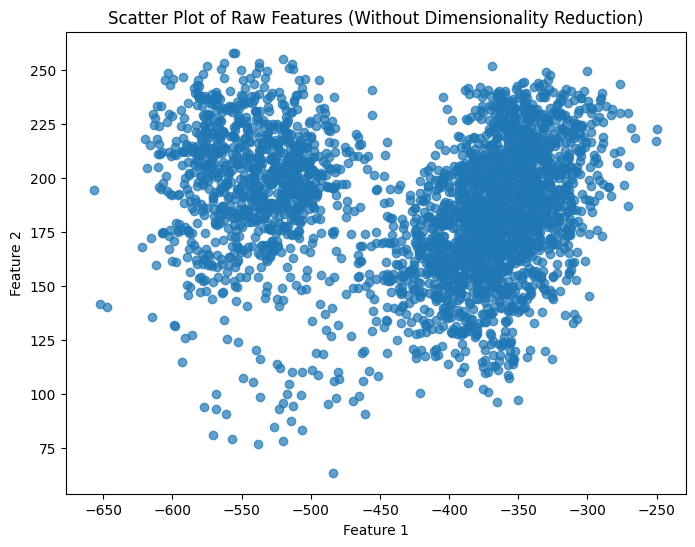

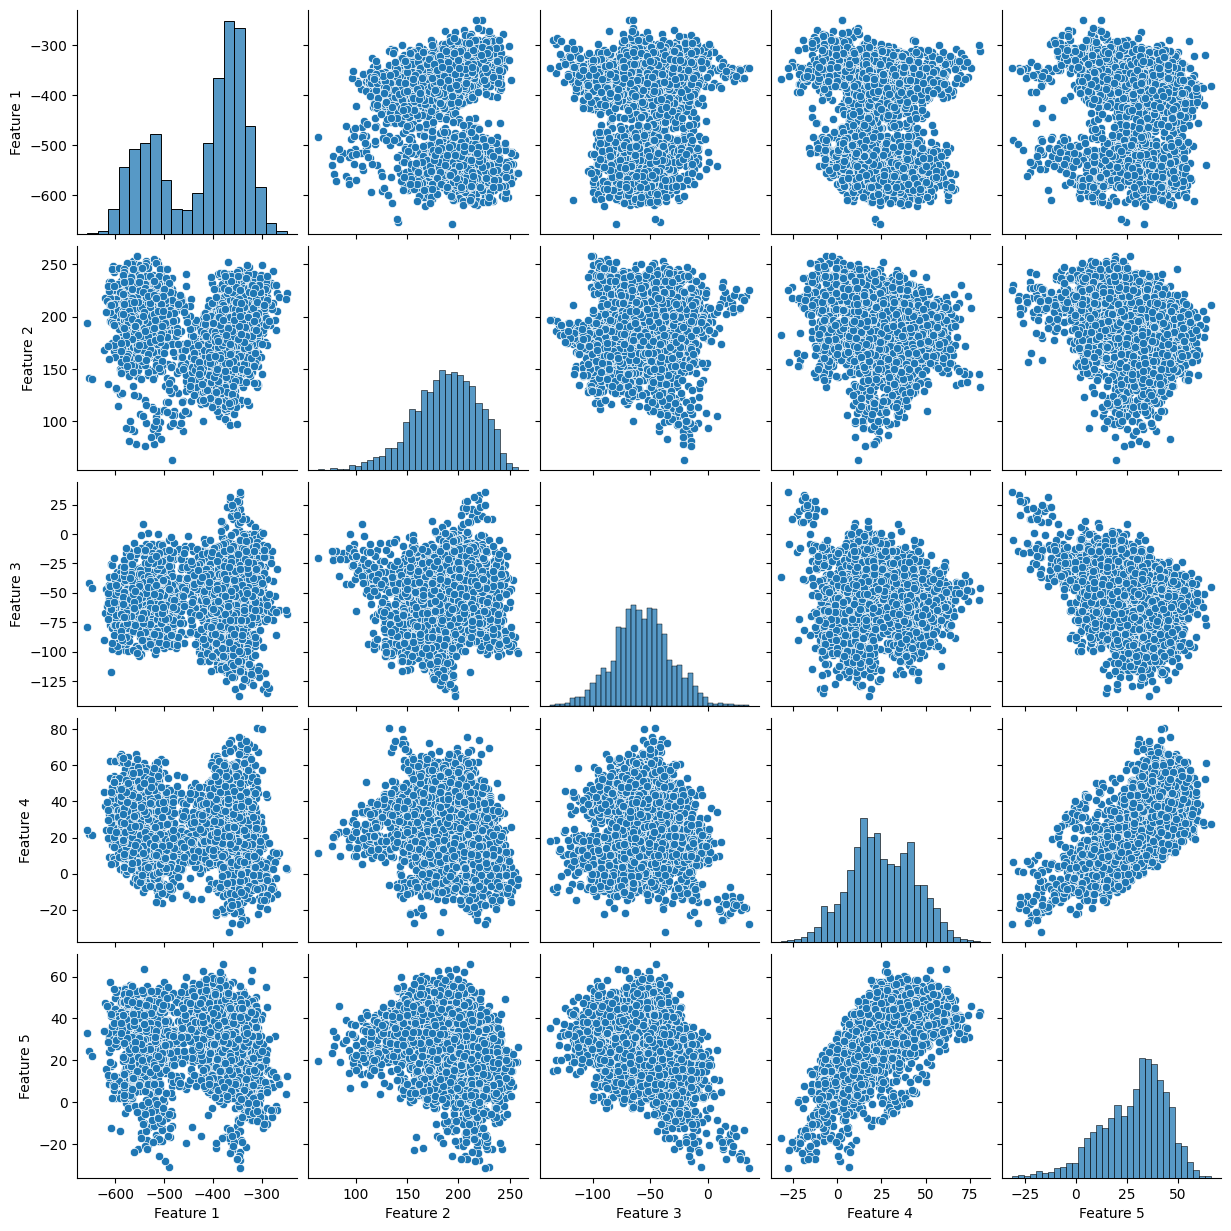

In [39]:
# Scatter plot (Attempt without dimensionality reduction)
plt.figure(figsize=(8,6))
plt.scatter(features_array[:, 0], features_array[:, 1], alpha=0.7)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Scatter Plot of Raw Features (Without Dimensionality Reduction)")
plt.show()

# Pair plot (Only using first 5 features)
df = pd.DataFrame(features_array[:, :5], columns=[f'Feature {i+1}' for i in range(5)])
sns.pairplot(df)
plt.show()



### Why is dimensionality reduction important?
Visualizing high-dimensional data directly is impossible hence dimensionality reduction help to project the data onto 2D and 3D spaces for easier visualization

Secondly, high-dimensional data often contains correlated features. Dimensionality reduction can help in identifying and removing these correlations, leading to more robust models.

Lastly, dimensionality reduction helps in filtering noise in a dataset, a common problem with high dimensional data.

(**Document any challenges/errors from the above experiments.**)

The dataset has more than two features hence plotting the scatter plot using the first two features does not capture the whole structure of the data well making the plot to be misleading.

Pair plots become impractical and less informative as the number of features increases. With many features, the number of subplots grows exponentially, making it hard to interpret.

Also, using only the first five features ignores important information contained in the other features, leading to incomplete analysis.


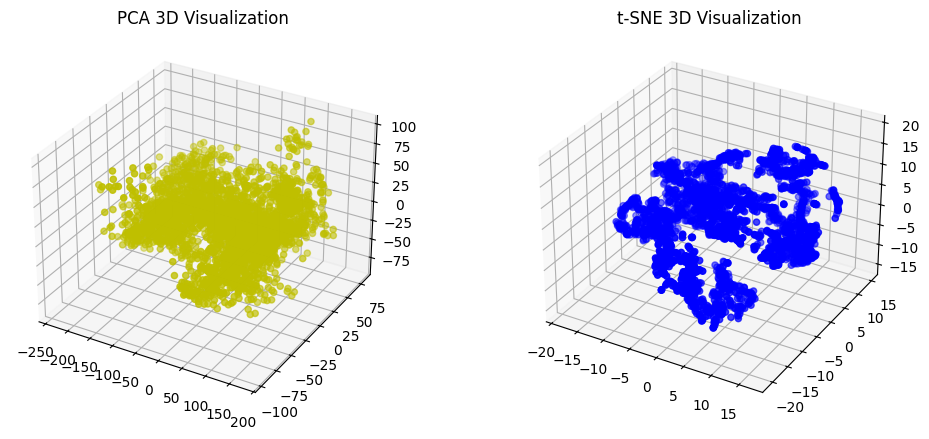

In [41]:
# Apply PCA (3 components)
pca = PCA(n_components=3)
features_pca = pca.fit_transform(features_array)

# Apply t-SNE (3 components)
tsne = TSNE(n_components=3, perplexity=30, random_state=42)
features_tsne = tsne.fit_transform(features_array)

# 3D Visualization
fig = plt.figure(figsize=(12, 5))

# PCA 3D plot
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(features_pca[:, 0], features_pca[:, 1], features_pca[:, 2], c='y', marker='o')
ax1.set_title('PCA 3D Visualization')

# t-SNE 3D plot
ax2 = fig.add_subplot(122, projection='3d')
ax2.scatter(features_tsne[:, 0], features_tsne[:, 1], features_tsne[:, 2], c='b', marker='o')
ax2.set_title('t-SNE 3D Visualization')

plt.show()


### Which method (PCA or t-SNE) provides better separability of clusters and why?
(*Write based on your visualizations.*)

In the t-SNE plot, the data points form several dense clusters have clear gaps between them, indicating better separability. In contrast, the PCA plot shows a more homogeneous distribution of data points without clear separations.

Therefore, t-SNE provides better separability of clusters compared to PCA because t-SNE is designed to preserve the local structure of the data, which means it maintains the relative distances between points that are close to each other. This results in clearer and more distinct clusters.

Unlike PCA, which is a linear technique, t-SNE can capture and represent non-linear relationships within the data. This allows it to reveal complex structures and patterns that PCA has missed.


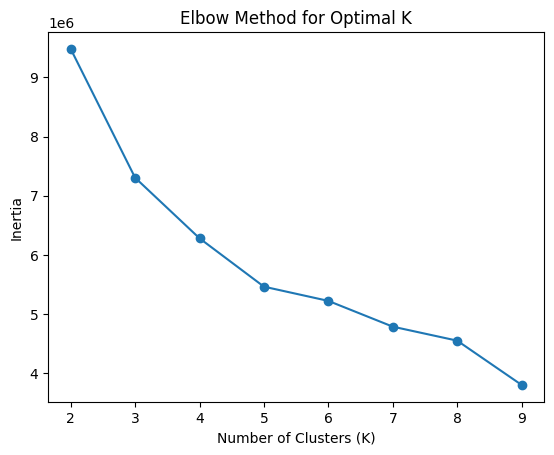

In [44]:

# Optimize number of clusters using Elbow Method
# Finding optimal K for K-Means using Elbow Method
inertia = []
K_range = range(2, 10)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    inertia.append(kmeans.inertia_)

plt.plot(K_range, inertia, marker="o")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.show()


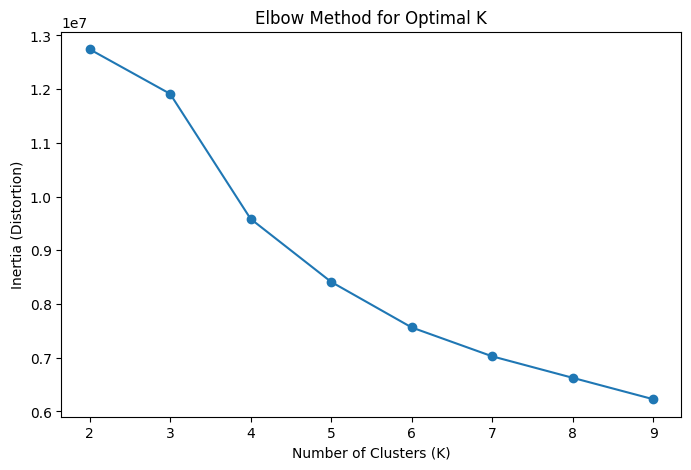

In [48]:
distortions = []
K_range = range(2, 10)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_array)
    distortions.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K_range, distortions, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Distortion)")
plt.title("Elbow Method for Optimal K")
plt.show()

# Set optimal K
optimal_k = 3

In [55]:
# Apply K-Means with optimal K (from Elbow method)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
labels_kmeans = kmeans.fit_predict(features_pca)

# Apply DBSCAN
dbscan = DBSCAN(eps=2, min_samples=5)
labels_dbscan = dbscan.fit_predict(features_pca)


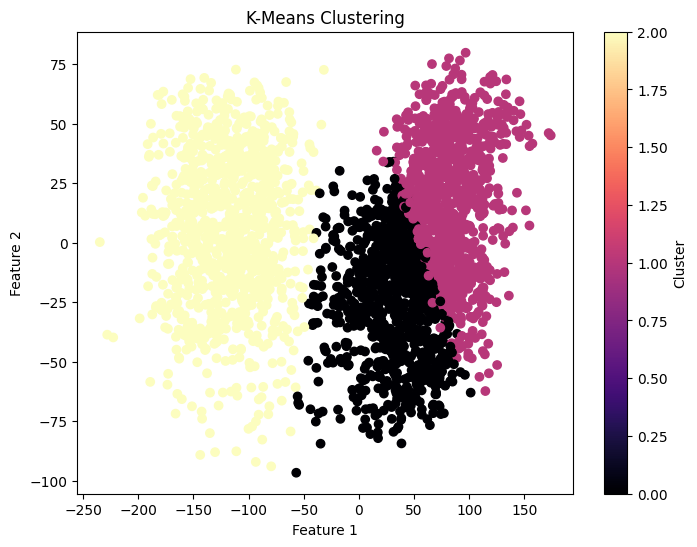

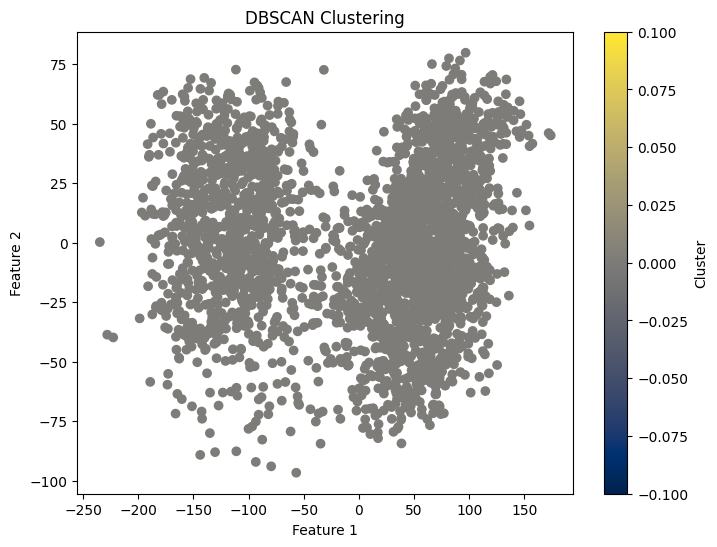

In [60]:
# Apply K-Means with optimal clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(features_pca)

# Apply DBSCAN Clustering
dbscan = DBSCAN(eps=2.5, min_samples=2)
dbscan_labels = dbscan.fit_predict(features_pca)

from sklearn.preprocessing import StandardScaler

#scale the data:
features_scaled = StandardScaler().fit_transform(features_array)
dbscan = DBSCAN(eps=5, min_samples=3)
dbscan_labels = dbscan.fit_predict(features_scaled)

# Scatter Plot for K-Means
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=kmeans_labels, cmap='magma', marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("K-Means Clustering")
plt.colorbar(label='Cluster')
plt.show()

# Scatter Plot for DBSCAN
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=dbscan_labels, cmap='cividis', marker='o')
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("DBSCAN Clustering")
plt.colorbar(label='Cluster')
plt.show()




In [62]:
# Evaluate clustering
kmeans_silhouette = silhouette_score(features_pca, kmeans_labels)
kmeans_db_index = davies_bouldin_score(features_pca, kmeans_labels)

if len(set(dbscan_labels)) > 1:
    dbscan_silhouette = silhouette_score(features_pca, dbscan_labels)
    dbscan_db_index = davies_bouldin_score(features_pca, dbscan_labels)
else:
    dbscan_silhouette = None
    dbscan_db_index = None

# Print Evaluation Results
print(f"K-Means - Silhouette Score: {kmeans_silhouette:.4f}, Davies-Bouldin Index: {kmeans_db_index:.4f}")
if dbscan_silhouette is not None:
    print(f"DBSCAN - Silhouette Score: {dbscan_silhouette:.4f}, Davies-Bouldin Index: {dbscan_db_index:.4f}")
else:
    print("DBSCAN failed to form meaningful clusters.")


K-Means - Silhouette Score: 0.3801, Davies-Bouldin Index: 1.0625
DBSCAN failed to form meaningful clusters.


### Discuss the results (max 5 lines)
(*Compare K-Means and DBSCAN performance based on the outputs.*)

**K-Means Clustering** - Silhouette Score of 0.3801 indicates moderate cluster separation but not very strong. Davies-Bouldin Index of 1.0625 suggests that the clusters are reasonably well-formed but can be improved.

**DBSCAN Clustering** - DBSCAN failed to produce meaningful clusters in this case due to wrong choice of parameters I think.Or probably the dataset is not suitable for DBSCAN clustering. I am not so sure.


Therefore, K-Means performed better than DBSCAN. It managed to form clusters, albeit with moderate quality.

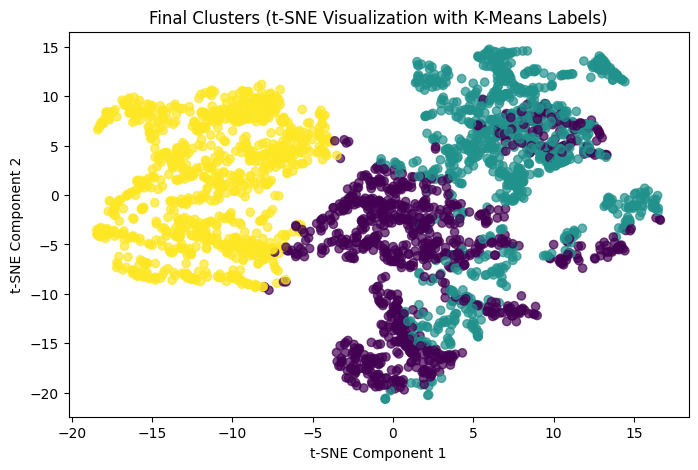

In [63]:

# Final visualization using t-SNE
plt.figure(figsize=(8, 5))
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=kmeans_labels, cmap='viridis', alpha=0.7)
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.title("Final Clusters (t-SNE Visualization with K-Means Labels)")
plt.show()


### Final Analysis
- Explain why dimensionality reduction helped (or didn't) in clustering.
- Justify why certain clustering methods worked better.
- Relate findings to real-world clustering challenges.

- Dimensionality reduction helped by reducing noise so that I can focus on the most important features thus better clustering results. It improved visualization of clusters and data structure. It also helped the k-means algorithm to effectively group similar data points.
  
   However, the DBSCAN clustering algorithm was less sensitive to the curse of dimensionality and might have not benefitted as much from dimensionality reduction.



- K-Means performed better than DBSCAN because the data naturally formed spherical clusters but the problem is that K-Means requires the number of clusters to be specified in advance, which can be a limitation.

  DBSCAN on the other hand is effective for identifying clusters of varying shapes and sizes, as well as detecting outliers. If the data would have contained noise or clusters of different densities, DBSCAN would outperform K-Means. Also, DBSCAN does not require the number of clusters to be specified, which can be an advantage.


- In the real world:

Data often has many features hence dimensionality reduction is crucial to make clustering feasible and meaningful.

Data is often noisy and contains outliers. Clustering methods like DBSCAN, which are robust to noise, can be more effective in such scenarios.

The optimal number of clusters is not known in advance. Methods like DBSCAN or hierarchical clustering, which do not require specifying the number of clusters, can be more flexible and practical.

It's often important to interpret the clusters. Dimensionality reduction can help by simplifying the data and making it easier to visualize and understand the clusters.

Datasets can be very large. Clustering algorithms need to be scalable to handle large datasets efficiently. Dimensionality reduction can help by reducing the size of the data, but the choice of clustering algorithm also plays a role in scalability.

